In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
from scipy.constants import c

In [2]:
file = open("sim_data.pkl", "rb")

sim_data = pickle.load(file)

file.close()

In [3]:
#sim_data = sim_data.astype(np.complex64)

In [4]:
gridsize = 100

In [5]:
# Define the range for phi[0] and phi[1]
x_values = np.linspace(-50, 50, gridsize)  # 0 to 50 (inclusive)
y_values = np.linspace(0, 50, gridsize)

# Create a grid of all combinations of phi[0] and phi[1]
X, Y = np.meshgrid(x_values, y_values)

# Flatten the grid and stack with phi[2] = 0, phi[3] = 0
phis = [np.array([[x], [y], [0], [0]]) for x, y in zip(X.ravel(), Y.ravel())]

# Convert to NumPy array (shape: (2500, 4, 1))
phis = np.array(phis)

print(f"Shape of phis: {phis.shape}")  # Expected: (2500, 4, 1)
#print(phis[:-2])  # Print first few vectors

Shape of phis: (10000, 4, 1)


In [4]:
M = np.array([[1, 0, 0.1, 0],
            [0, 1, 0, 0.1],
            [0, 0, 1, 0],
            [0, 0, 0, 1]])

mu_a = np.array([[0],
                [0],
                [0],
                [0]])

Lambda_a = np.diagflat([0.5,0.5,0.1,0.1])

G = np.diagflat([(0.1**2)/2,(0.1**2)/2,0.1,0.1])

phi = np.array([[10],
                    [10],
                    [0],
                    [0]])

### Computation of first term:

$$
\underset{\boldsymbol{\phi}_{-1}}{\mathbb{E}}\left[\ln \left(p\left(\boldsymbol{\phi}_0 \mid \boldsymbol{\phi}_{-1}, \boldsymbol{\mu}_{\boldsymbol{a}}, \boldsymbol{\Lambda}_{\boldsymbol{a}}\right)\right)\right]
$$

as

$$
 \propto - (\phi_n - M \phi_{n-1} - G \boldsymbol{\mu}_a)^\top \underbrace{(G^\top \boldsymbol{\Lambda}_a^{-1} G)^{-1}}_{\tilde{\boldsymbol{\Lambda}}} (\phi_n - M \phi_{n-1} - G \boldsymbol{\mu}_a) + \text{const}(\boldsymbol{\Lambda}_a).
$$



In [5]:
magnitudes = np.array([])

for n in range(len(phis)):
    first_term = -(phis[n]-M@phi - G@mu_a).T @ (np.linalg.inv(G.T @ np.linalg.inv(Lambda_a) @ G)) @ (phis[n]-M@phi - G@mu_a)
    magnitudes = np.append(magnitudes, first_term)

NameError: name 'phis' is not defined

#### Computation of the second term

$$
\underset{\boldsymbol{\phi}_{-1}}{\mathbb{E}}\left[\ln \left(p\left(\boldsymbol{Z}_0 \mid \boldsymbol{\phi}_0\right)\right)\right]+\text { const. }
$$

by


$$
\left.\ln \left(p\left(\boldsymbol{Z}_n \mid \boldsymbol{\phi}_n\right)\right) \propto\left|\left\langle\boldsymbol{S}_n\left(\boldsymbol{\phi}_n\right)\right| \boldsymbol{\Lambda}_z\right| \boldsymbol{Z}_n\right\rangle \mid
$$


In [6]:
bw = 0.77*1e9

T_c = 25.66e-6
S = bw/T_c

Ns = 256
fs = 20e6

max_range = (fs*c)/(2*S)

wavelength = c/77e9

def compute_IF(r):
    IF_signal = (S*(2*r))/ c
    return IF_signal

def distance(x, y):
    return np.linalg.norm([np.array([[0], [0]]), np.array([[x], [y]])])

tx = np.array(([-12*(wavelength/2), 0],
        [-8*(wavelength/2), 0],
        [-4*(wavelength/2), 0]))

rx = np.array(([-(3/2)*(wavelength/2), 0],
                                    [-(1/2)*(wavelength/2), 0],
                                    [(1/2)*(wavelength/2), 0],
                                    [(3/2)*(wavelength/2), 0]))


def get_phase(x, y):
    distances = np.zeros((3, 4))
    for tx_idx in range(3):
        for rx_idx in range(4):
            distances[tx_idx,rx_idx] = np.linalg.norm(tx[tx_idx] - np.array([[x], [y]]).T) + np.linalg.norm(rx[rx_idx] - np.array([[x], [y]]).T)
            # Compute the phase difference between the antennas
    phase_diff_TX_RX = 2*np.pi*distances/wavelength
    phase_diff_TX_RX -= phase_diff_TX_RX[0,0]
    return phase_diff_TX_RX

In [7]:
omega = np.linspace(0, 2*np.pi*fs, Ns)
times = np.linspace(0, Ns/fs, Ns)

S_signals = []


for n in tqdm(range(len(phis))):
    S_n_all_virtuals = np.zeros([12*256], dtype=complex)
    for virtual_antennas in (range(12)):
        r = distance(phis[n, 0, 0], phis[n, 1, 0])
        f_if = compute_IF(r)
        phases = get_phase(phis[n, 0, 0], phis[n, 1, 0])
        phases = np.reshape(phases, (1, 12))
        S_n = (np.sqrt((1 * 1 * (wavelength ** 2) * 1) / (((4 * np.pi) ** 3) * ((r) ** 4))))* 2*T_c*np.sinc((omega - 2*np.pi*f_if)*2*T_c) * np.exp(1j*phases[0, virtual_antennas])
        #S_n = (np.sqrt((1 * 1 * (wavelength ** 2) * 1) / (((4 * np.pi) ** 3) * ((r) ** 4)))) * np.exp(1j * (2 * np.pi * f_if * times + phases[0, virtual_antennas]))
        #S_n = np.fft.fft(S_n)
        S_n_all_virtuals[virtual_antennas*256:(virtual_antennas+1)*256] = S_n
    S_signals.append(S_n_all_virtuals)

NameError: name 'phis' is not defined

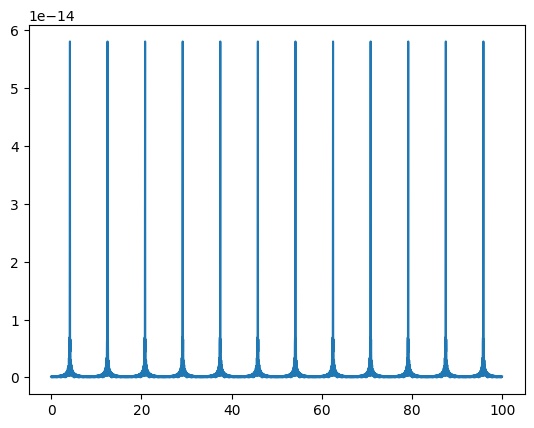

In [10]:
plt.plot(np.linspace(0, max_range, 3072), np.abs(S_signals[0][0:3072]))

(3072, 1)


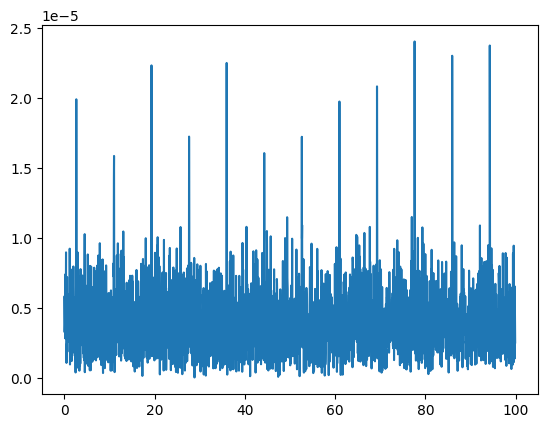

In [77]:
sim_data_all_virtual = sim_data[30,:,:,0,:]
sim_data_all_virtual = sim_data_all_virtual.reshape(12*256)[:, np.newaxis]
print(sim_data_all_virtual.shape)

range_fourier = np.concatenate([np.fft.fft(sim_data_all_virtual[i:i+256, 0]) for i in range(0, len(sim_data_all_virtual), 256)])

plt.plot(np.linspace(0, max_range, 3072), np.abs(range_fourier))

In [78]:
Lambda_z = np.eye(3072) * 0.2

# Convert S_signals to a NumPy array for vectorized operations
S_signals_array = np.array(S_signals)#, dtype=np.complex64)

# Normalize the data while preserving the complex values
range_fourier_normalized = np.abs(range_fourier) / np.max(np.abs(range_fourier))
generated_signal_normalized = np.abs(S_signals_array) / np.max(np.abs(S_signals_array))


# Compute the bra_op_ket for all phis at once
bra_op_ket = np.abs(generated_signal_normalized @ Lambda_z @ range_fourier_normalized)

# Store the result in second_term
second_term = bra_op_ket

In [84]:
second_term.shape

(10000,)

In [80]:
"""def BLaT(Z, mu_a, Lambda_a, x_start, y_start):

    sigma_tilde_hat = 1
    r_hat = np.sqrt(x_start**2 + y_start**2)
    v_hat = np.array([[0],
                      [0]])
    
    noise_power = 7.63889188576458e-12

    phi = np.array([[50],
                    [50],
                    [0],
                    [0]])
    
    M = np.array([[1, 0, 0.1, 0],
                  [0, 1, 0, 0.1],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]])
    
    G = np.diagflat([(0.1**2)/2,(0.1**2)/2,0.1,0.1])

    for n in range(Z.shape[0]):

        alpha = 0

        if n == 0:
            first_term = -(phi-M@mu_a - G@mu_a).T @ (np.linalg.inv(G.T @ np.linalg.inv(Lambda_a) @ G)) @ (phi-M@mu_a - G@mu_a)
            #second_term = 
            print(first_term)
        if n == 1:
            phi_est
        else:
            phi_est


BLaT(sim_data, np.array([[0],
                         [0],
                         [0],
                         [0]]), np.diagflat([0.5,0.5,0.1,0.1]), 10, 10)"""

'def BLaT(Z, mu_a, Lambda_a, x_start, y_start):\n\n    sigma_tilde_hat = 1\n    r_hat = np.sqrt(x_start**2 + y_start**2)\n    v_hat = np.array([[0],\n                      [0]])\n    \n    noise_power = 7.63889188576458e-12\n\n    phi = np.array([[50],\n                    [50],\n                    [0],\n                    [0]])\n    \n    M = np.array([[1, 0, 0.1, 0],\n                  [0, 1, 0, 0.1],\n                  [0, 0, 1, 0],\n                  [0, 0, 0, 1]])\n    \n    G = np.diagflat([(0.1**2)/2,(0.1**2)/2,0.1,0.1])\n\n    for n in range(Z.shape[0]):\n\n        alpha = 0\n\n        if n == 0:\n            first_term = -(phi-M@mu_a - G@mu_a).T @ (np.linalg.inv(G.T @ np.linalg.inv(Lambda_a) @ G)) @ (phi-M@mu_a - G@mu_a)\n            #second_term = \n            print(first_term)\n        if n == 1:\n            phi_est\n        else:\n            phi_est\n\n\nBLaT(sim_data, np.array([[0],\n                         [0],\n                         [0],\n                       

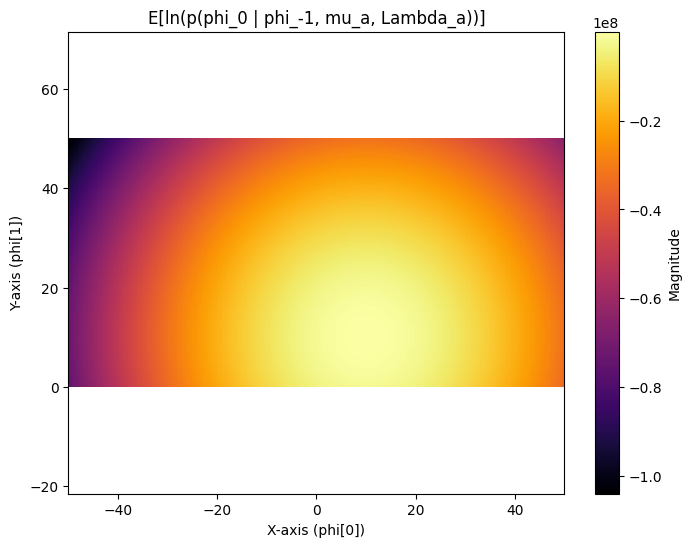

In [81]:
# Compute the magnitude (ignoring phi[2] and phi[3])
#magnitudes = np.sqrt(phis[:, 0, 0]**2 + phis[:, 1, 0]**2)

# Reshape to 2D (51x51) for heatmap plotting
heatmap = magnitudes.reshape(gridsize, gridsize)

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap, origin='lower', extent=[-50, 50, 0, 50], cmap='inferno', aspect='auto')
plt.colorbar(label="Magnitude")
plt.xlabel("X-axis (phi[0])")
plt.ylabel("Y-axis (phi[1])")
plt.title("E[ln(p(phi_0 | phi_-1, mu_a, Lambda_a))]")
plt.axis('equal')
plt.show()


In [82]:
print(np.argmax(heatmap))
magnitudes[np.argmax(heatmap)]

2059


np.float64(-3469.033772064034)

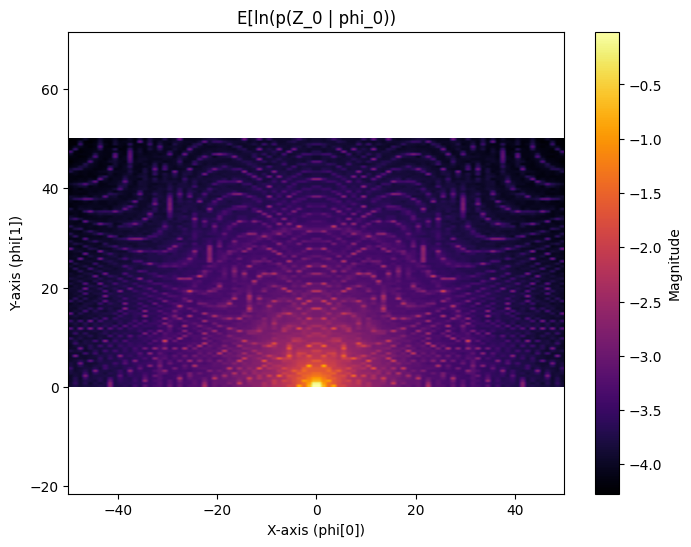

In [83]:
# Compute the magnitude (ignoring phi[2] and phi[3])
#magnitudes = np.sqrt(phis[:, 0, 0]**2 + phis[:, 1, 0]**2)

# Reshape to 2D (51x51) for heatmap plotting
heatmap = second_term.reshape(gridsize, gridsize)

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(np.log10(np.abs(heatmap)), origin='lower', extent=[-50, 50, 0, 50], cmap='inferno', aspect='auto')
plt.colorbar(label="Magnitude")
plt.xlabel("X-axis (phi[0])")
plt.ylabel("Y-axis (phi[1])")
plt.title("E[ln(p(Z_0 | phi_0))")
plt.axis('equal')
plt.show()

In [44]:
print(np.argmax(heatmap))
second_term[np.argmax(heatmap)]

50


np.float64(0.19915524313684801)